In [2]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
import sagemaker.amazon.common as smac
import numpy as np

region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
stores_key = 'stores.csv'
transactions_key = 'transactions.csv'


store = 's3://{}/{}/{}'.format(bucket, prefix, stores_key)
transaction = 's3://{}/{}/{}'.format(bucket, prefix, transactions_key)

stores = pd.read_csv(store)
transactions = pd.read_csv(transaction)

region

Matplotlib is building the font cache; this may take a moment.


'eu-west-2'

In [3]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [4]:
stores = transactions.merge(stores)

stores['date'] = pd.to_datetime(stores['date'])

pd.to_datetime(stores.index)
stores = stores.rename(columns={'date': 'dates'})

missing = pd.date_range(start="2013-01-01", end="2017-12-25")
missing = pd.DataFrame(missing, columns=['dates'])
#stores = outer_merged = pd.merge(stores, missing, how="outer", on=['dates'])
stores = pd.merge(stores, missing, how="outer", on=['dates'])
stores = stores.sort_values('dates')
#stores = stores.set_index('date')
#stores = stores.interpolate(method='nearest')
stores['month'] = stores['dates'].dt.month
stores['year'] = stores['dates'].dt.year
stores['week'] = stores['dates'].dt.week
stores['day'] = stores['dates'].dt.day
stores = stores.set_index('dates')
stores[stores['year'] == 2017].tail(400)

/tmp/ipykernel_7722/2380212652.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  stores['week'] = stores['dates'].dt.week


,store_nbr,transactions,city,state,type,cluster,month,year,week,day
dates,,,,,,,,,,
2017-08-11,44.0,4418.0,Quito,Pichincha,A,5.0,8,2017,32,11
2017-08-11,43.0,1532.0,Esmeraldas,Esmeraldas,E,10.0,8,2017,32,11
2017-08-11,38.0,1577.0,Loja,Loja,D,4.0,8,2017,32,11
2017-08-11,39.0,1170.0,Cuenca,Azuay,B,6.0,8,2017,32,11
2017-08-11,37.0,1122.0,Cuenca,Azuay,D,2.0,8,2017,32,11
...,...,...,...,...,...,...,...,...,...,...
2017-12-21,NaN,NaN,NaN,NaN,NaN,NaN,12,2017,51,21
2017-12-22,NaN,NaN,NaN,NaN,NaN,NaN,12,2017,51,22
2017-12-23,NaN,NaN,NaN,NaN,NaN,NaN,12,2017,51,23


# EDA

In [5]:
corr = stores.corr()
corr

/tmp/ipykernel_7722/155214244.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = stores.corr()


,store_nbr,transactions,cluster,month,year,week,day
store_nbr,1.000000,0.189311,-0.078323,0.003649,0.016848,0.004348,-0.000190
transactions,0.189311,1.000000,0.196014,0.037838,-0.037086,0.027368,-0.020544
cluster,-0.078323,0.196014,1.000000,-0.000089,-0.014887,-0.000467,0.000392
month,0.003649,0.037838,-0.000089,1.000000,-0.148114,0.977264,-0.008123
year,0.016848,-0.037086,-0.014887,-0.148114,1.000000,-0.148667,-0.011015
week,0.004348,0.027368,-0.000467,0.977264,-0.148667,1.000000,0.057536
day,-0.000190,-0.020544,0.000392,-0.008123,-0.011015,0.057536,1.000000


Text(0.5, 1.0, 'Correlation heatmap')

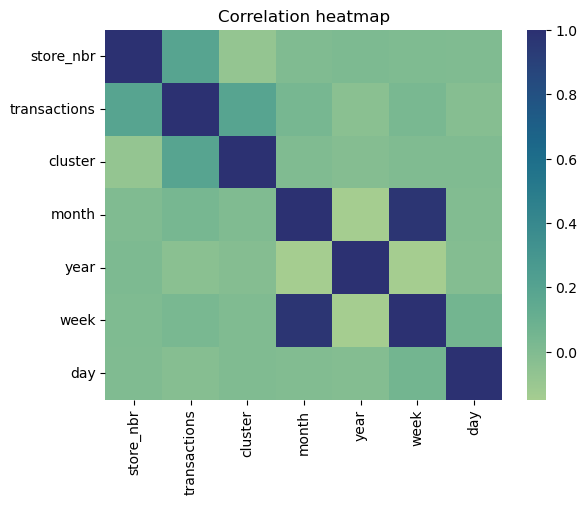

In [7]:
sns.heatmap(data=corr, cmap='crest')
plt.title('Correlation heatmap')

Text(0.5, 1.0, 'Distribution of transactions')

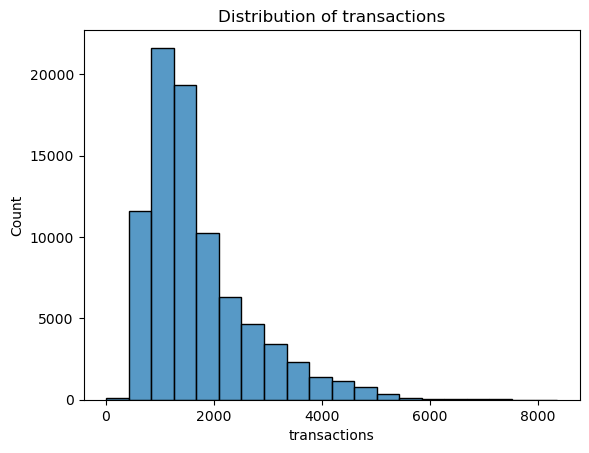

In [8]:
sns.histplot(stores['transactions'], bins=20)
plt.title('Distribution of transactions')

<AxesSubplot: xlabel='city', ylabel='transactions'>

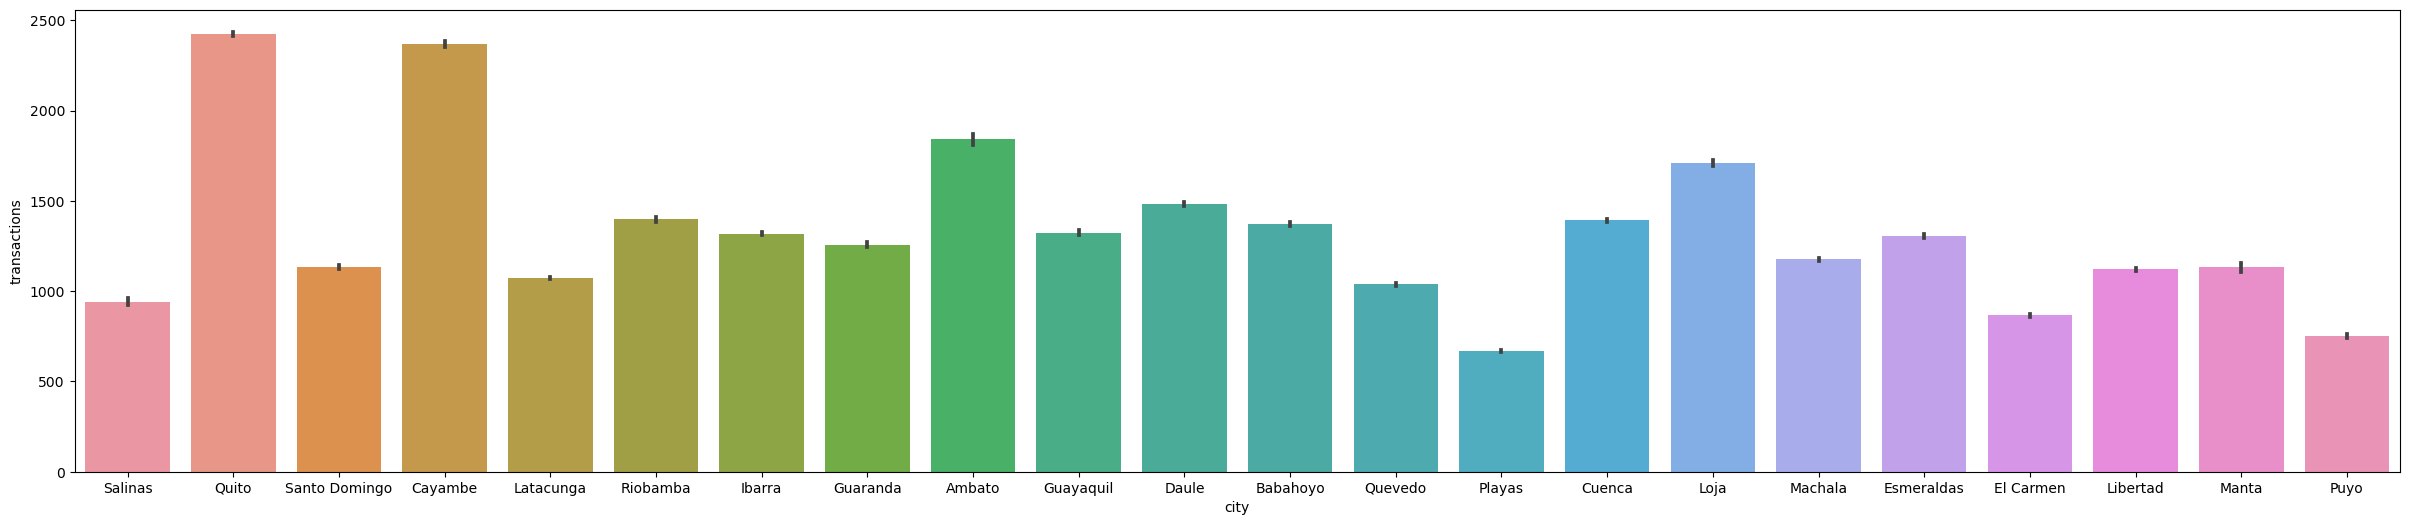

In [50]:
plt.figure(figsize=(30,6))

sns.barplot(data=stores, x='city', y='transactions')

<AxesSubplot: xlabel='state', ylabel='transactions'>

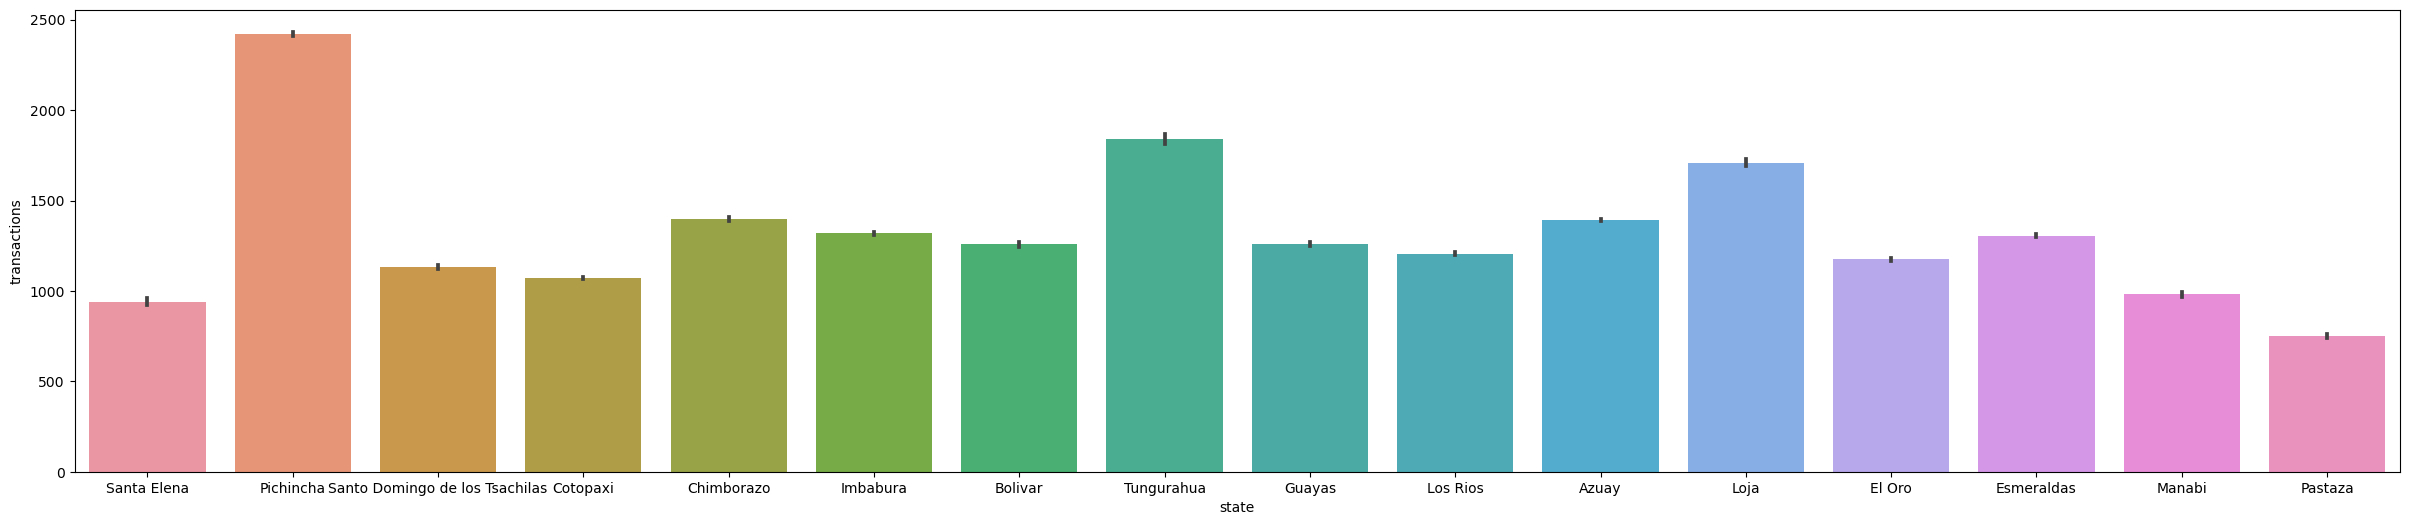

In [51]:
plt.figure(figsize=(30,6))

sns.barplot(data=stores, x='state', y='transactions')

<AxesSubplot: ylabel='transactions'>

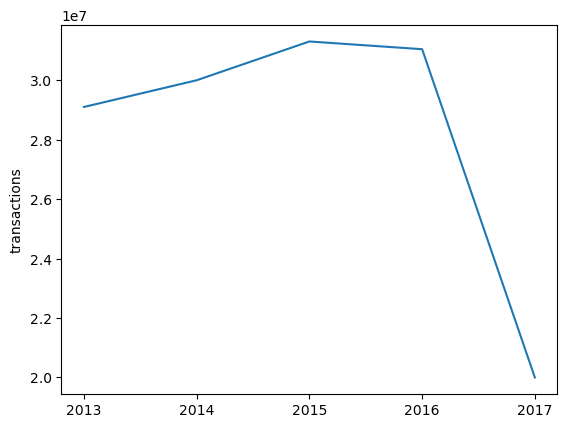

In [52]:
months = stores.month.unique()

transaction_per_week = stores.groupby('week')['transactions'].sum()
transaction_per_month = stores.groupby('month')['transactions'].sum()
transaction_per_year = stores.groupby('year')['transactions'].sum()

sns.lineplot(x=stores['year'].unique().astype(str), y=transaction_per_year)

<AxesSubplot: ylabel='transactions'>

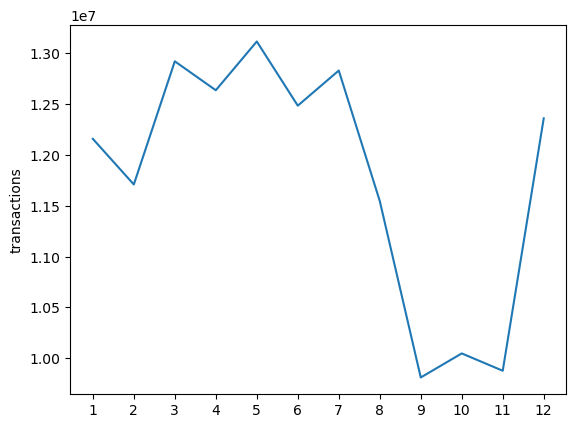

In [53]:
sns.lineplot(x=stores['month'].unique().astype(str), y=transaction_per_month)

<AxesSubplot: ylabel='transactions'>

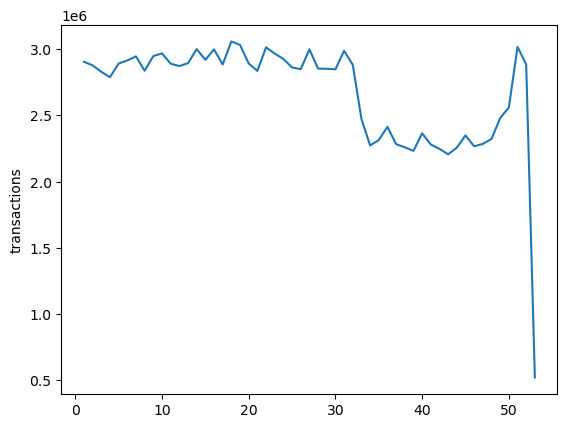

In [54]:
sns.lineplot(x=stores['week'].unique(), y=transaction_per_week)

,year,month,transactions
0,2013,1,2289558
1,2013,2,2169615
2,2013,3,2458683
3,2013,4,2344905
4,2013,5,2467465
5,2013,6,2392206
6,2013,7,2401968
7,2013,8,2461139
8,2013,9,2380462
9,2013,10,2408440


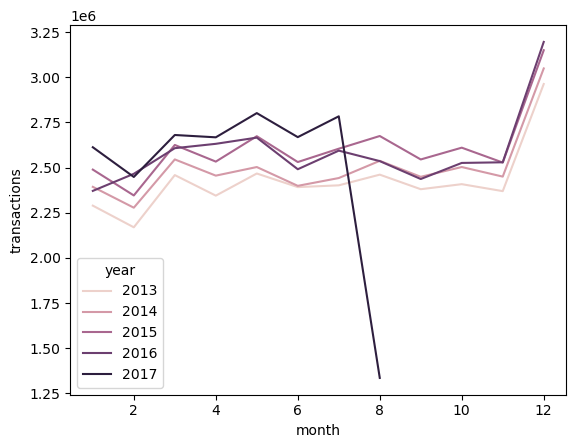

In [55]:
transactions_per_year = stores.groupby(['year','month'])['transactions'].sum()
transactions_per_year = pd.DataFrame(transactions_per_year)
transactions_per_year = transactions_per_year.reset_index()

sns.lineplot(data=transactions_per_year, x=transactions_per_year['month'], y=transactions_per_year['transactions'],hue=transactions_per_year['year'])

# Cleaning

In [56]:
target = stores['transactions']
stores = stores.drop('transactions', axis = 1)
stores = stores.drop('date', axis=1)
stores = stores.drop('store_nbr', axis=1)

stores = pd.concat([target, stores], axis = 1)
stores

,transactions,city,state,type,cluster,month,year,week,day
0,770,Salinas,Santa Elena,D,1,1,2013,1,1
1,1038,Salinas,Santa Elena,D,1,1,2013,1,2
2,887,Salinas,Santa Elena,D,1,1,2013,1,3
3,1054,Salinas,Santa Elena,D,1,1,2013,1,4
4,1355,Salinas,Santa Elena,D,1,1,2013,1,5
...,...,...,...,...,...,...,...,...,...
83483,2957,Manta,Manabi,A,11,8,2017,32,11
83484,2804,Manta,Manabi,A,11,8,2017,32,12
83485,2433,Manta,Manabi,A,11,8,2017,32,13
83486,2074,Manta,Manabi,A,11,8,2017,33,14


In [57]:
city = pd.get_dummies(stores['city'])
#states = pd.get_dummies(stores['state'])
types = pd.get_dummies(stores['type'])
#month = pd.get_dummies(stores['month'])
#year = pd.get_dummies(stores['year'])
cluster = pd.get_dummies(stores['cluster'])

stores = pd.concat([stores, city], axis=1)
#stores = pd.concat([stores, states], axis=1)
stores = pd.concat([stores, types], axis=1)
#stores = pd.concat([stores, month], axis=1)
#stores = pd.concat([stores, year], axis=1)
stores = pd.concat([stores, cluster], axis=1)

stores = stores.drop(['city', 'state', 'type', 'cluster', 'year'], axis=1)
stores

,transactions,month,week,day,Ambato,Babahoyo,Cayambe,Cuenca,Daule,El Carmen,...,8,9,10,11,12,13,14,15,16,17
0,770,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1038,1,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,887,1,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1054,1,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1355,1,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83483,2957,8,32,11,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
83484,2804,8,32,12,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
83485,2433,8,32,13,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
83486,2074,8,33,14,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [79]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

stores.columns = stores.columns.astype(str)

y = stores['transactions']

x = stores.drop('transactions', axis=1)

x = scaler.fit_transform(x)

x = pd.DataFrame(x)

x.insert(loc=0, column='target', value=y)

x.columns = range(x.columns.size)

print(x)

train_data, validation_data, test_data = np.split(
    x.sample(frac=1, random_state=1729),
    [int(0.7 * len(stores)), int(0.9 * len(stores))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

train_data

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


         0         1         2         3    4    5    6    7    8    9   ...  \
0       770  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1      1038  0.000000  0.000000  0.033333  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2       887  0.000000  0.000000  0.066667  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3      1054  0.000000  0.000000  0.100000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4      1355  0.000000  0.000000  0.133333  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...     ...       ...       ...       ...  ...  ...  ...  ...  ...  ...  ...   
83483  2957  0.636364  0.596154  0.333333  0.0  0.0  0.0  0.0  0.0  0.0  ...   
83484  2804  0.636364  0.596154  0.366667  0.0  0.0  0.0  0.0  0.0  0.0  ...   
83485  2433  0.636364  0.596154  0.400000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
83486  2074  0.636364  0.615385  0.433333  0.0  0.0  0.0  0.0  0.0  0.0  ...   
83487  2255  0.636364  0.615385  0.466667  0.0  0.0  0.0  0.0  0.0  0.0  ...   

        38   39   40   41   42   43   4

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
36241,2003,0.909091,0.884615,0.766667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78460,586,0.909091,0.903846,0.766667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
54265,1528,0.818182,0.788462,0.366667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35537,2897,1.000000,0.961538,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65595,4758,0.636364,0.653846,0.966667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58237,1136,0.454545,0.461538,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25551,1408,0.545455,0.576923,0.900000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15936,2070,0.545455,0.519231,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40440,902,0.636364,0.596154,0.233333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
bucket = sagemaker.Session().default_bucket()
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [81]:
bucket

'sagemaker-eu-west-2-866647877267'

In [82]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")

s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [83]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="reg:squarederror",
    num_round=100,
)

#xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

In [19]:
from sagemaker.serializers import CSVSerializer

xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-03-16-11-47-25-188
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-03-16-11-47-25-188
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-03-16-11-47-25-188


------!

In [20]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return predictions.split("\n")[:-1]

predictions = predict(test_data.values[:, 1:])
predictions

['1700.89111328125',
 '2495.9892578125',
 '1065.4232177734375',
 '1498.09326171875',
 '756.9893188476562',
 '3351.318115234375',
 '912.6353759765625',
 '1767.8775634765625',
 '1697.1689453125',
 '2434.146728515625',
 '1456.093017578125',
 '1803.8074951171875',
 '2047.76220703125',
 '954.02197265625',
 '768.6753540039062',
 '1270.644287109375',
 '4251.6552734375',
 '3461.835205078125',
 '1205.64697265625',
 '1205.64697265625',
 '1165.4158935546875',
 '2050.660888671875',
 '1786.95458984375',
 '632.312255859375',
 '1444.0421142578125',
 '1157.09716796875',
 '1758.1424560546875',
 '1448.8017578125',
 '965.927734375',
 '1232.514404296875',
 '1340.324951171875',
 '761.055419921875',
 '1873.341796875',
 '722.7470092773438',
 '1719.8897705078125',
 '675.7556762695312',
 '782.5811767578125',
 '2608.542724609375',
 '1360.8673095703125',
 '566.4595947265625',
 '1269.20556640625',
 '2480.230224609375',
 '4231.91064453125',
 '3304.1474609375',
 '1098.5816650390625',
 '3206.328857421875',
 '2125.27

In [44]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
predictions = np.array(predictions, dtype=float)
mae_score = mean_absolute_error(test_data['transactions'], predictions)
MSE = mean_squared_error(test_data['transactions'], predictions)
r2 = r2_score(test_data['transactions'], predictions)
print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))
print("The R^2 Error of our Model is {}".format(round(r2, 2)))

The Mean Absolute Error of our Model is 253.83
The R^2 Error of our Model is 0.84


In [87]:
tuning_job_config = {
    "ParameterRanges": {
      "ContinuousParameterRanges": [
        {
          "MaxValue": "0.5",
          "MinValue": "0.01",
          "Name": "eta"
        },
        {
          "MaxValue": "100",
          "MinValue": "1",
          "Name": "min_child_weight"
        },
        {
          "MaxValue": "4",
          "MinValue": "1",
          "Name": "alpha"
        },
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "200",
          "MinValue": "80",
          "Name": "num_round"
        },  
        {
          "MaxValue": "8",
          "MinValue": "1",
          "Name": "max_depth"
        },
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 500,
      "MaxParallelTrainingJobs": 10
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:mae",
      "Type": "Minimize"
    },
    "RandomSeed" : 123
  }

In [88]:
s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/validation/'.format(bucket, prefix)

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "mae",
      "objective": "reg:squarederror",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

In [89]:
smclient = boto3.Session().client('sagemaker')
tuning_job_name = "DS-CHALL24"
tuner = smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)


In [ ]:
best_overall_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)["BestTrainingJob"]

best_overall_training_job

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
predictions = np.array(predictions, dtype=float)
mae_score = mean_absolute_error(test_data['transactions'], predictions)
MSE = mean_squared_error(test_data['transactions'], predictions)
r2 = r2_score(test_data['transactions'], predictions)
print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))
print("The R^2 Error of our Model is {}".format(round(r2, 2)))

In [ ]:
xgb_predictor.delete_model()
xgb_predictor.delete_endpoint()